# Method for using snowslide in a classic workflow

Snowslide is a python module designed to redistribute snow by simulating avalanches based on an initial snow height situation and a digital terrain model. The algorithm was designed based largely on the work of Bernhardt & Schulz (2010) [1] and Gruber (2007) [2]. 

OLD VERSION : (These two functions are identical in terms of simulation, but snowslide_base simply returns the snow height matrix after simulation, whereas snowslide_complete provides the convergence trend and snow heights at each iteration. It also offers the option of displaying results in 2D and 3D for users who want to work specifically on snowslide results. However, these capabilities greatly reduce the computational speed of the algorithm and are not of greater scientific interest for most users. In this notebook we will therefore focus solely on the operation of the snowslide_base function.)

## Step 1 : import snowslide

In [1]:
import numpy as np 
import rasterio
import xarray
import matplotlib.pyplot as plt

import os

In [2]:
import snowslide

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
import logging
logging.getLogger("fiona").setLevel(logging.CRITICAL)
logging.getLogger("shapely").setLevel(logging.CRITICAL)
logging.getLogger("rasterio").setLevel(logging.CRITICAL)
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)
logging.getLogger("numexpr").setLevel(logging.CRITICAL)
logging.getLogger("numba").setLevel(logging.CRITICAL)

logging.basicConfig(level=logging.DEBUG)

## Step 2 : initialize snowslide

Snowslide requires at least two parameters to work: 
- (1) a path to a .tif file containing the dem (you need to enter a path and not the table directly because snowslide is based on the pysheds module).
- (2) An np.array of the same size as the dem giving the initial snow heights. With the current functionality, it's up to the user to decide how they want to initialise this table (ideal data, real data, etc.) and how often they want to trigger avalanches and therefore reset this table. In the future, snowslide should offer methods for initialising snow heights from real data according to user requests... 

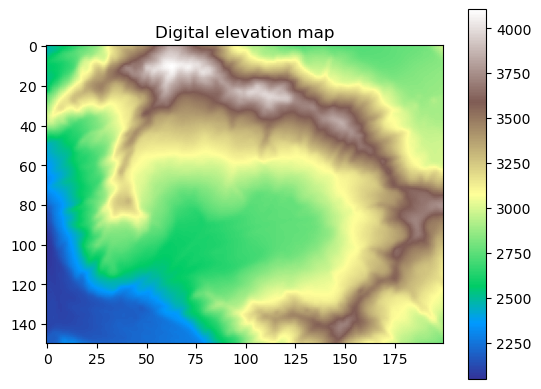

In [4]:
# The user must give the path to the dem file as input 
dem_path = "dem.tif"

# Plotting code
plt.imshow(rasterio.open(dem_path).read(1),cmap='terrain')
plt.title('Digital elevation map')
plt.colorbar()

Then the user must define a matrix of same size as the dem to initialize snowslide. Let's call this matrix SND0 (for initial Snow Depths). For the example let's juste create a matrix that adds 1m of snow anywhere on the dem 

In [5]:
# The user must define a matrix of same size as the dem to initialize the model
shape = np.shape(rasterio.open(dem_path).read(1)) # gets the shape of the dem
snow_init = 1
snd0 = np.full(shape,float(snow_init)) # Initialize the snow depths with 1m over the whole dem

## Step 3 : launch simulation

In [6]:
snd = snowslide.snowslide_base(dem_path,snd0=snd0)

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
DEBUG:snowslide.snowslide_main:variables have been initialized, launching the simulation...


INFO:snowslide.snowslide_main:the algorithm converged in 104 iterations


Text(0.5, 1.0, 'Snow Depth after avalanches')

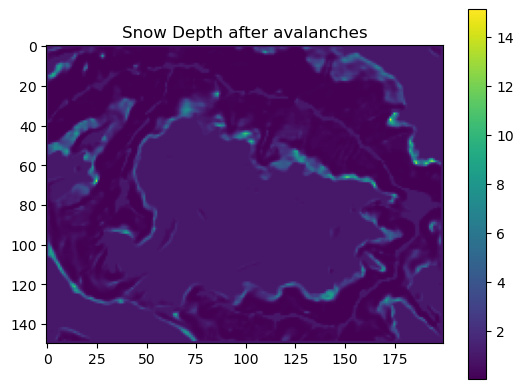

In [7]:
# PLotting
plt.imshow(snd)
plt.colorbar()
plt.title('Snow Depth after avalanches')

You've launched Snowslide and got the result - well done!

But snowslide also offers the user a little more freedom, particularly in the choice of a number of simulation parameters. Let's take a closer look. 

## Step 4 : closer look into simulation parameters and results

Snowslide allows you to choose input parameters in the form of dictionaries, booleans or floating numbers : 

    path_dem: str
        Path to the dem file (.tif)
    SND0: numpy.ndarray
        Numpy matrix of the same size as the dem containing the initial snow depths (derived from precipitation). 
    save_path: str
        Path where the user want to save the data produced (.tif file of the SND matrix). Default is None.
        If no path is indicated, no data is stored (only registered as a variable when running the function)
        If a path is indicated the matrix will be saved as 'converged_SND.tif' file
    epsilon: float
        Condition to get out the loop (convergence is considered reached when indicateur < epsilon). Default is 1e-3.
    param_expo: dictionary
        The maximum snow height each pixel can store is computed as an exponential function of the slope. Parameters are the following:
            SND_max=c*exp(a*slope)
        a: float
            Default is -0.14. 
        c: float
            Default is 145
        min: float
            Default is 0.05.
    param_routing: dictionary
        Parameters used by pysheds to realize the routing of the snow. 
        routing: str 
            routing method ('mfd' or 'd8')
        preprocessing: bolean
            activate or deactivate preprocessing of the DEM. Deactivate it affects convergence.
        compute_edges: bolean
            activate or deactivate computing of edges for the slope function
        

In [8]:
save_path = None # Indicating a path to a folder would store the convergence as a .tif file based on the georeferences data of the dem.tif
epsilon = 1e-3 # It affects the condition to consider the algorithm has converged. A more restrictive condition has shown little effect on the result. 
param_expo = {"a":0.14,"c":145,"min":0.05} # These are the parameters of the function linking the slope and the maximum amount of snow it can retain.
param_routing = {"routing":'mfd',"preprocessing":True,"compute_edges":True} # These are the parameters that define the type of routing 

These parameters can be modified according to the user's wishes. In particular, the parameterisation of the exponential function determining the maximum quantity of snow that can be retained by a pixel with a given slope can be adjusted using the parameters defined in param_expo. One of the most interesting parameters for the user would be to modify the routing method used (d8 or mfd). We recommend the use of preprocessing (variable True) in the majority of cases, but it has been shown to be a source of problems on very regular concave dem's. Nevertheless, in the case of real data, it ensures the convergence of the algorithm towards the correct solution. compute_edges simply indicates that the edges of the matrix are calculated when the slope is estimated. This slows down the algorithm but it is considered negligible, so the parameter is True by default. 

now, let's give an example of simulations with different routing parameters :

In [10]:
dem_path = "dem.tif"
shape = np.shape(rasterio.open(dem_path).read(1))
snow_init = 1
snd0 = np.full(shape,float(snow_init))
param_routing = {"routing":'mfd',"preprocessing":True,"compute_edges":True}

# 'mfd' method routing
snd1 = snowslide.snowslide_base(dem_path,snd0=snd0,param_routing = param_routing)

# 'd8' method routing
param_routing = {"routing":'d8',"preprocessing":True,"compute_edges":True}
snd2 = snowslide.snowslide_base(dem_path,snd0=snd0,param_routing = param_routing)

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
DEBUG:snowslide.snowslide_main:variables have been initialized, launching the simulation...


INFO:snowslide.snowslide_main:the algorithm converged in 104 iterations
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
DEBUG:snowslide.snowslide_main:variables have been initialized, launching the simulation...
INFO:snowslide.snowslide_main:the algorithm converged in 75 iterations


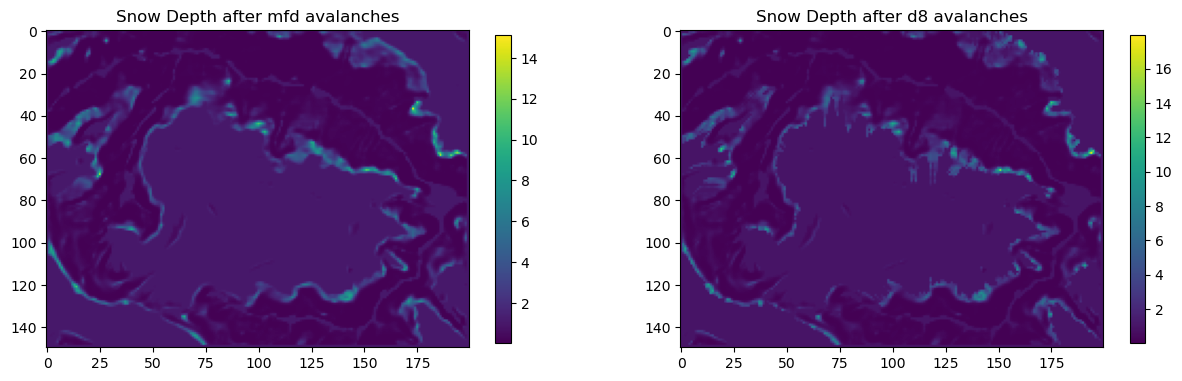

In [18]:
# Plotting code 
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot1 = ax[0].imshow(snd1)
ax[0].set_title('Snow Depth after mfd avalanches')
plt.colorbar(plot1,ax=ax[0],shrink=0.8)
plot2 = ax[1].imshow(snd2)
ax[1].set_title('Snow Depth after d8 avalanches')
plt.colorbar(plot2,ax=ax[1],shrink=0.8)

We leave it up to the user to also play with other modifiable parameters, such as the parameters linked to the exponential function relating slope and quantity of snow retained. 

## Step 5 : use of inside functions that are used successively in the simulation

The snowslide package is built on a serie of function that are called successively in ``snowslide_main.py``. These functions can be found in the ``snowslide/functions.py`` file. Their uses and roles are described in the readme but we will take a quick look at how they work independently, which will lift the veil on the inner workings of snowslide. 

In [19]:
# Importing functions
from snowslide.functions import *

#### 5.1 - Calculating a slope

In [20]:
dem = rasterio.open(dem_path).read(1) # Open DEM as an equivalent of an np array
resolution =  rasterio.open(dem_path).res
dem_slope = slope(dem,resolution[0],resolution[1],compute_edges=True)

Text(0.5, 1.0, 'Slope in °')

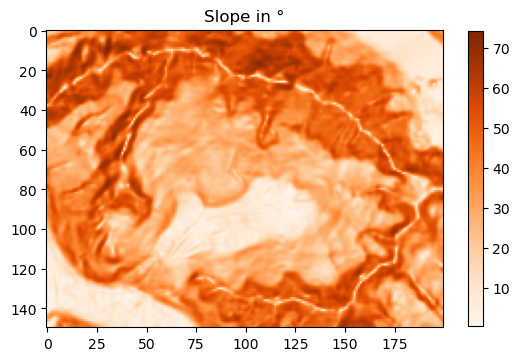

In [23]:
# Plotting code 
plt.imshow(dem_slope,cmap='Oranges')
plt.colorbar(shrink=0.8)
plt.title('Slope in °')

This slope calculation is based on the algorithm defined by Berthold K.P. Horn (1981) [3] and reused in the gdal python library.

#### 5.2 - Calculating the relation between slope and maximal snow height held

This function called ``snd_max_exponential()`` computes the maximal height of snow each pixel can store based on the slope. It is an exponential and default parameters are estimated from 'Bernhardt & Schulz 2010'. This function can be viewed in the ReadMe.

In [42]:
a = 0.14
c = 145
min = 0.05
snd_max = snd_max_exponential(dem_slope, a, c, min)

Text(0.5, 1.0, 'Maximum snow height depending on the slope (m)')

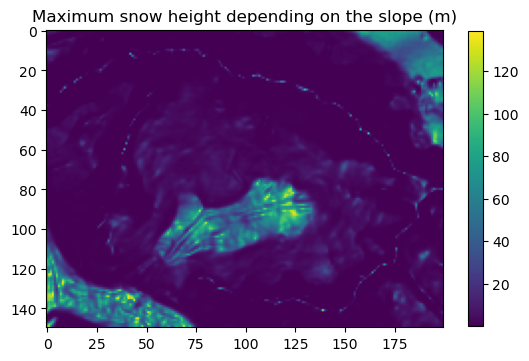

In [43]:
# Plotting code 
plt.imshow(snd_max)
plt.colorbar(shrink=0.8)
plt.title('Maximum snow height depending on the slope (m)')

#### 5.3 - Calculating the snow redistribution to each neighbour in mfd routing at step 1

In [40]:
# Using pysheds python package 
from pysheds.grid import Grid
grid = Grid.from_raster(dem_path)
dem = grid.read_raster(dem_path)

hnso = dem + snd0
routing = 'mfd'
preprocessing = True

flow_dir = dem_flow(hnso, grid, routing=routing, preprocessing=preprocessing)

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


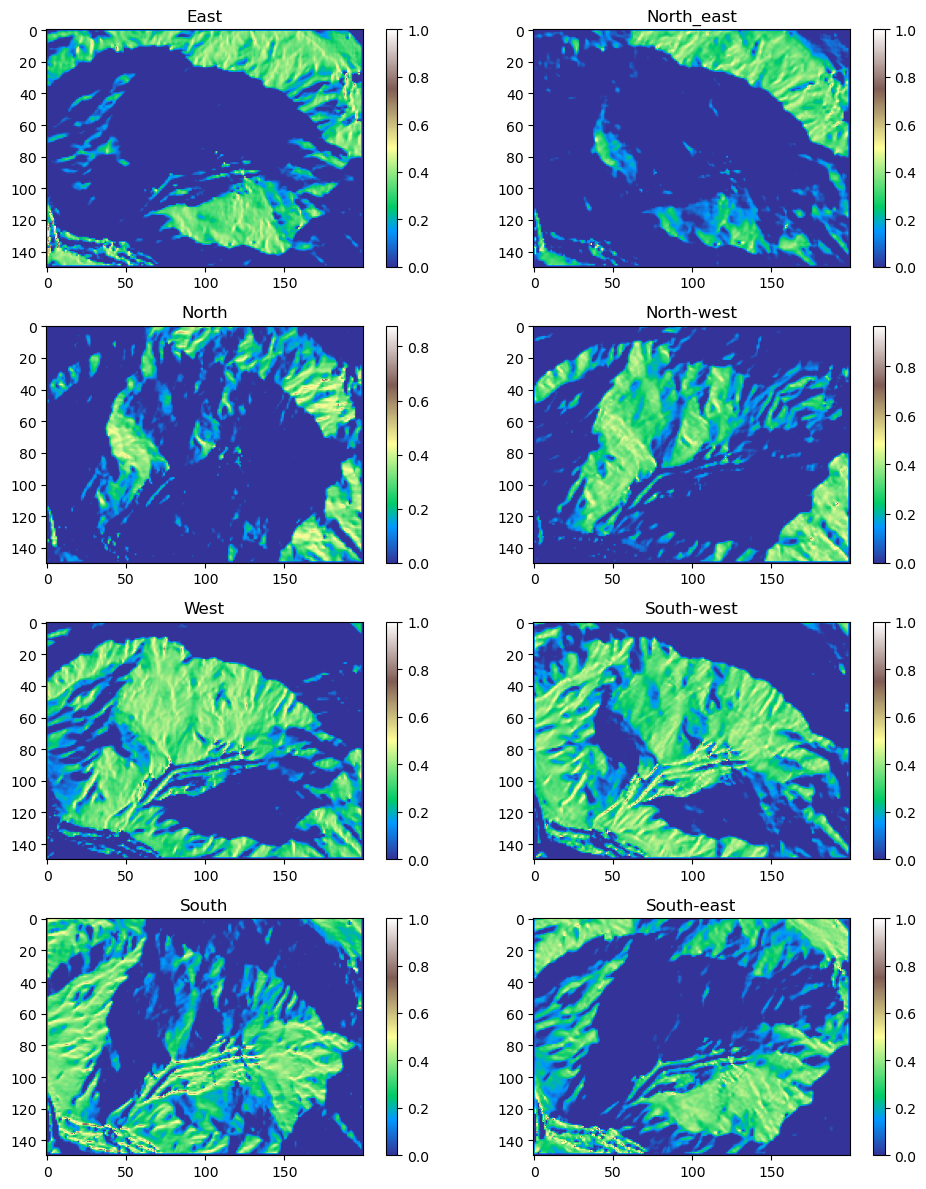

In [41]:
# Plotting code
fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(10,12))
coord = ('East','North_east','North','North-west','West','South-west','South','South-east')
n=0
for i in range(4) :
    for j in range(2) :
        ax[i,j].set_title(coord[n])
        im = ax[i,j].imshow(flow_dir[n], cmap='terrain')
        plt.colorbar(im,ax=ax[i,j])
        n+=1
plt.tight_layout()

These matrices give the coefficient assigned to each of the cardinal and diagonal neighbours of each pixel. More details are available in the pysheds documentation available as a resource [4].

#### 5.4 - Operating the routing of the snow for 1 step

In [44]:
snd = snow_routing(snd0, snd_max, flow_dir, routing)

Text(0.5, 1.0, 'SND after 1st step routing (m)')

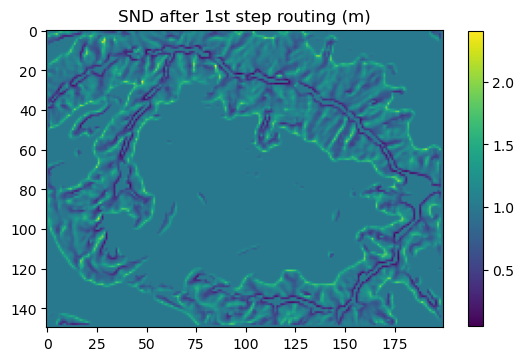

In [48]:
# Plotting code 
plt.imshow(snd)
plt.colorbar(shrink=0.8)
plt.title('SND after 1st step routing (m)')

Ensuite, en plus de quelques calculs annexes nécessaires, l'algorithme snowslide défini dans ``snowslide_main.py`` multiplie ces étapes jusqu'à convergence de l'algorithme, c'est à dire jusqu'à que la matrice des hauteurs de neige n'évolue plus d'itération en itération.

### Bibliography

[1] - M. Bernhardt, K. Schulz. (2010). SnowSlide: A simple routine for calculating gravitational snow transport. Geophysical research letters, vol. 37, L11502.
<br> [2] - Gruber, S. (2007), A mass-conserving fast algorithm to parameterize gravitational transport and deposition using digital elevation models, Water Resour. Res., 43, W06412.
<br> [3] - Berthold K.P. HORN. (1981). Hill Shading and the Reflectance Map. PROCEEDINGS OF THE IEEE, VOL.69, NO. 1, JANUARY1981.
<br> [4] - https://mattbartos.com/pysheds/flow-directions.html